In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import Dependencies

In [48]:
import torch
import torch.nn as nn # Deep Learning Network 기본 구성 요소를 포함한 torch.nn 모듈을 nn으로 지정 
import torch.nn.functional as F # torch.nn.functional 을 F 로 지정
import torch.optim as optim 
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

from matplotlib import pyplot as plt # Data 시각화를 돕는 matplotlib 모듈 
%matplotlib inline  

from google.colab.patches import cv2_imshow


# Device Definition 

In [49]:
use_cuda = torch.cuda.is_available() 
device = torch.device("cuda" if use_cuda else "cpu")

# Define Hyperparameters

In [50]:
input_size = 784 # img_size = (28,28) ---> 28 x 28 = 784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 50 # the size of input data took for one iteration "= mini batch size" 
lr = 1e-3 # size of step 

# Downloading MNIST data

In [51]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

print('number of training data : ',len(train_data))
print('number of test data : ',len(test_data))


number of training data :  60000
number of test data :  10000


# MNIST Data Check

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

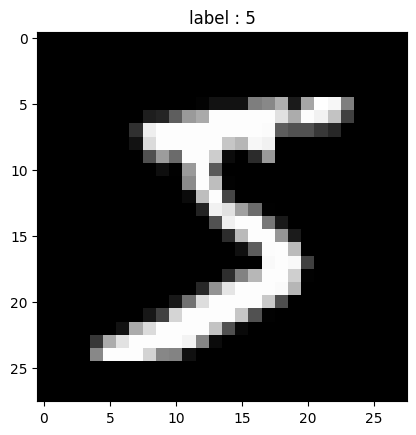

In [52]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %s' % label)
plt.imshow

# Loading the data

In [53]:
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

# Define model class

In [54]:
class MyLeNet5_1 (nn.Module): 
  def __init__(self): 
    super(MyLeNet5_1, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size = 5, padding = 2)
    self.maxpool_1 = nn.MaxPool2d(kernel_size=(2,2), stride = 2)
    self.conv_2 = nn.Conv2d(6, 16, kernel_size = 5)
    self.maxpool_2 = nn.MaxPool2d(kernel_size=(2,2), stride = 2)
    self.conv_3 = nn.Conv2d(16, 120, kernel_size = 5)
    self.relu = nn.ReLU()
    self.fc_1 = nn.Linear(120, 84)
    self.fc_2 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv_1(x)
    x = self.relu(x)
    x = self.maxpool_1(x)
    x = self.conv_2(x)
    x = self.relu(x)
    x = self.maxpool_2(x)
    x = self.conv_3(x)
    x = x.view(-1, 120) 
    x = self.fc_1(x)
    x = self.relu(x)
    res = self.fc_2(x)
    return res 

model1 = MyLeNet5_1()
print(model1)

MyLeNet5_1(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool_1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (fc_1): Linear(in_features=120, out_features=84, bias=True)
  (fc_2): Linear(in_features=84, out_features=10, bias=True)
)


In [55]:
class MyLeNet5_2(nn.Module): 
  def __init__(self):
    super(MyLeNet5_2, self).__init__() 
    self.conv_layers = nn.Sequential(
      nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(6, 16, kernel_size=5), nn.Dropout(),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(16, 120, kernel_size=5) 
      )
    self.fc_layers = nn.Sequential( nn.Linear(120, 84), nn.ReLU(),
      nn.Linear(84, 10)
      )
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(-1, 120) # flatten 
    x = self.fc_layers(x)
    return x
model = MyLeNet5_2() 
print(model)

MyLeNet5_2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


# Define Loss Function & Optimizer

In [56]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training the Model 1

In [57]:
model1.train()
model = model1.to(device)
i = 0 # Loss Function 현황을 확인하고자, 학습 횟수를 나타내는 보조 index 지정

for epoch in range(num_epochs):
  for data, target in train_gen:
    data = data.to(device) 
    target = target.to(device)
    optimizer.zero_grad() # optimizer gradient 초기화 
    output = model(data)
    loss = loss_function(output, target)
    loss.backward() 
    optimizer.step()

    if i % 1000 == 0:
      print('Train Step: {}\tloss: {:.3f}'.format(i, loss.item()))
    i +=1



Train Step: 0	loss: 2.306
Train Step: 1000	loss: 2.307
Train Step: 2000	loss: 2.309
Train Step: 3000	loss: 2.317
Train Step: 4000	loss: 2.296
Train Step: 5000	loss: 2.296
Train Step: 6000	loss: 2.303
Train Step: 7000	loss: 2.313
Train Step: 8000	loss: 2.299
Train Step: 9000	loss: 2.300
Train Step: 10000	loss: 2.315
Train Step: 11000	loss: 2.296
Train Step: 12000	loss: 2.314
Train Step: 13000	loss: 2.303
Train Step: 14000	loss: 2.300
Train Step: 15000	loss: 2.298
Train Step: 16000	loss: 2.301
Train Step: 17000	loss: 2.300
Train Step: 18000	loss: 2.315
Train Step: 19000	loss: 2.299
Train Step: 20000	loss: 2.307
Train Step: 21000	loss: 2.297
Train Step: 22000	loss: 2.312
Train Step: 23000	loss: 2.319


# Model Evaluation

In [58]:
model.eval()
model = model.to(device)
correct = 0 # 정답 개수 저장 및 확인 

for data, target in test_gen:
  data = data.to(device)
  target = target.to(device)
  output = model(data)
  prediction = output.data.max(1)[1] # Softmax 값이 가장 큰 index를 예측
  correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_gen.dataset)))


Test set: Accuracy: 9.82%


# Visualization

In [59]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

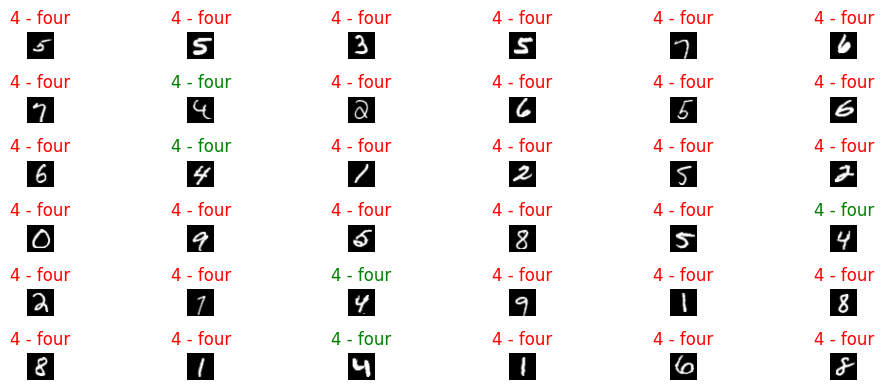

In [60]:
image, label = test_data[0]

# See random images with their labels
torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 6, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    img, label_gt = test_data[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();